In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf

import matplotlib.pyplot as plt
from time import time
from time import sleep
import re
import os
import argparse
import random
from collections import OrderedDict
import matplotlib.animation as animation

### Image processing ###
from scipy.ndimage import zoom
from scipy.spatial import distance
import imutils
from scipy import ndimage
import cv2
import dlib
from __future__ import division
from imutils import face_utils

### CNN models ###
from tensorflow import keras
import keras
from keras_preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from keras.callbacks import TensorBoard
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Conv2D, MaxPooling2D, SeparableConv2D
from keras.utils import np_utils
from keras import regularizers
from keras.optimizers import SGD, RMSprop
from keras.utils import to_categorical
# from keras.layers import BatchNormalization
# from keras.applications.inception_v3 import BatchNormalization
# from keras.layers.normalization import BatchNormalization
from keras.layers.normalization.batch_normalization import BatchNormalization
from keras import models
from keras.utils.vis_utils import plot_model
from keras.layers import Input, GlobalAveragePooling2D
from keras.models import Model
from keras import layers, models, losses, metrics

### Build SVM models ###
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn import svm

### Same trained models ###
# import h5py
# from keras.models import model_from_json
import pickle

# to load train model
from tensorflow.keras.models import model_from_json

##### save the model weights
##### json_string = model.to_json()
##### model.save_weights(local_path + 'fer.h5')
##### open(local_path + 'fer.json', 'w').write(json_string)

In [3]:
shape_x = 48
shape_y = 48

In [4]:
def detect_face(frame):
    
    #Cascade classifier pre-trained model
    cascPath = '../../Models_face_detection_xml/FaceDetect/haarcascade_frontalface_default.xml'
    faceCascade = cv2.CascadeClassifier(cascPath)
    
    #BGR -> Gray conversion
    gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    
    #Cascade MultiScale classifier
    detected_faces = faceCascade.detectMultiScale(gray,scaleFactor=1.1,minNeighbors=6,
                                                  minSize=(shape_x, shape_y),
                                                  flags=cv2.CASCADE_SCALE_IMAGE)
    coord = []
    
    for x, y, w, h in detected_faces :
        if w > 100 :
            sub_img=frame[y:y+h,x:x+w]
            #cv2.rectangle(frame,(x,y),(x+w,y+h),(0, 255,255),1)
            coord.append([x,y,w,h])
    
    return gray, detected_faces, coord

In [5]:
def extract_face_features(faces, offset_coefficients=(0.075, 0.05)):
    gray = faces[0]
    detected_face = faces[1]
    
    new_face = []
    
    for det in detected_face :
        x, y, w, h = det
    
        #Offset coefficient, np.floor takes the lowest integer (delete border of the image)
        horizontal_offset = int(np.floor(offset_coefficients[0] * w))
        vertical_offset = int(np.floor(offset_coefficients[1] * h))

        #gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
        #gray transform image
        extracted_face = gray[y+vertical_offset:y+h, x+horizontal_offset:x-horizontal_offset+w]
    
        #Zoom 
        new_extracted_face = zoom(extracted_face, (shape_x / extracted_face.shape[0],shape_y / extracted_face.shape[1]))
        #cast type float
        new_extracted_face = new_extracted_face.astype(np.float32)
        #scale
        new_extracted_face /= float(new_extracted_face.max())
        #print(new_extracted_face)
    
        new_face.append(new_extracted_face)
    
    return new_face

In [6]:
path = '../../dataset/'
local_path = '../../dataset/'

In [7]:
with open(local_path + 'fer.json','r') as f:
    json = f.read()
model = model_from_json(json)

model.load_weights(local_path + 'fer.h5')
print("Loaded model from disk")

Loaded model from disk


### Make Prediction on an image

#### Random Image Picker

In [8]:
def pick_random_image(source_folder):
    # List all files in the source folder directory
    files = os.listdir(source_folder)

    # Filter out non-image files (you may want to adjust this filter based on your file types)
    image_files = [file for file in files if file.endswith(('.jpg', '.jpeg', '.png'))]
    
    # Check if there are any image files
    if not image_files:
        print("No image files found in the source folder.")
        return None
    
    # Pick a random image file
    random_image = random.choice(image_files)

    # Return the path to the randomly picked image
    return os.path.join(source_folder, random_image).replace("\\", "/")


source_folder = "../../TestPhoto/Celebrity"
random_image_path = pick_random_image(source_folder)
if random_image_path:
    print("Randomly picked image:", random_image_path)


Randomly picked image: ../../TestPhoto/Celebrity/Kingly-Black-And-White-Portraits-Of-Celebrities0201.jpg


In [9]:
random_image = random_image_path
random_image_face = cv2.imread(
    random_image_path
)

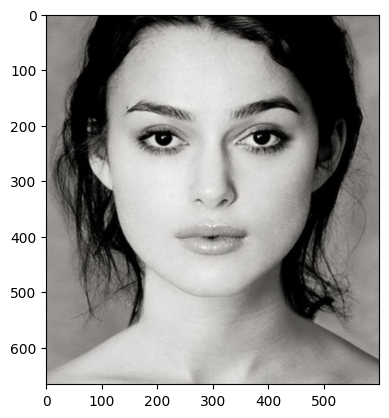

In [10]:
plt.imshow(cv2.cvtColor(random_image_face, cv2.COLOR_BGR2RGB))

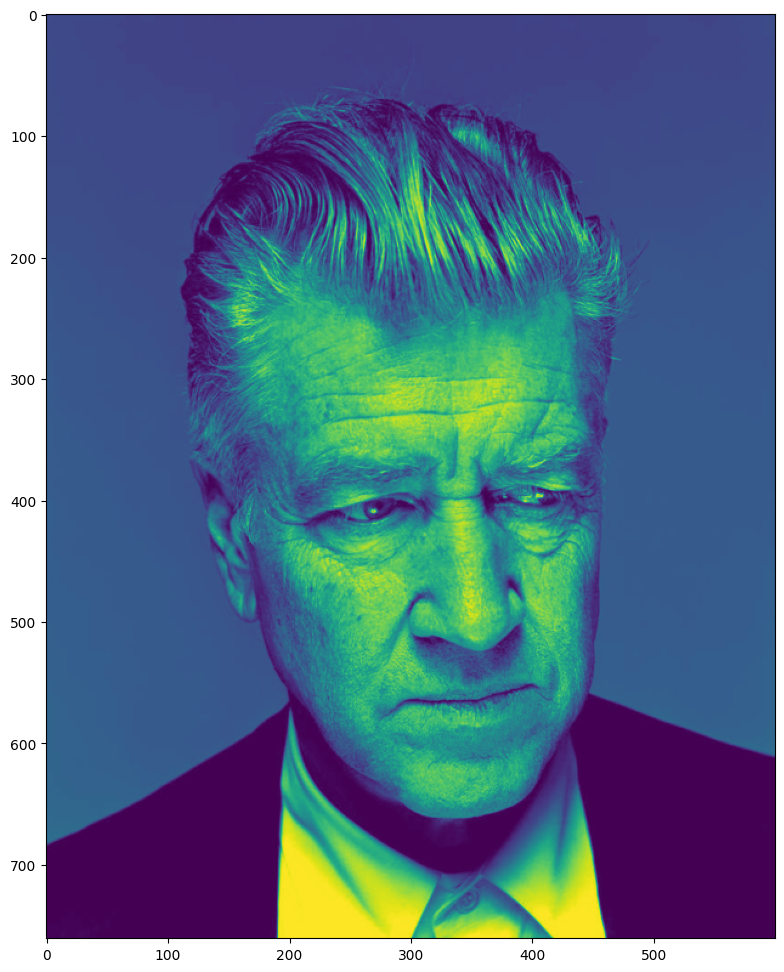

In [18]:
plt.figure(figsize=(12,12))
plt.imshow(detect_face(random_image_face)[0])
plt.show()

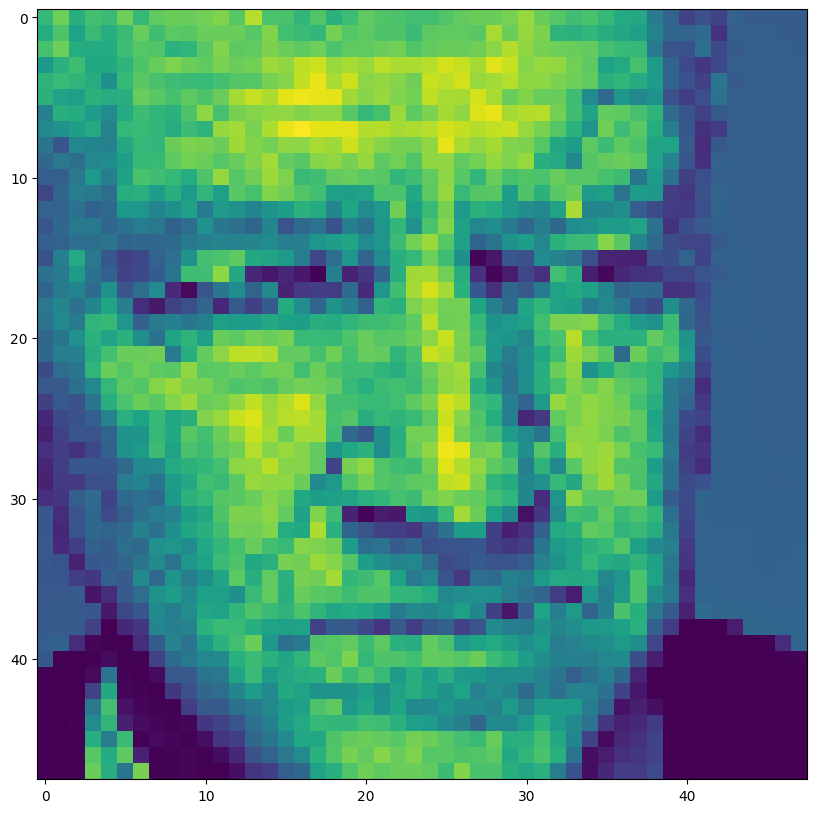

In [19]:
for face in extract_face_features(detect_face(random_image_face)) :
    plt.figure(figsize=(10,10))
    plt.imshow(face)
    plt.show()

#### {0:'Angry', 1:'Disgust', 2:'Fear', 3:'Happy', 4:'Sad' , 5:'Surprise', 6:'Neutral'}

In [20]:
for face in extract_face_features(detect_face(random_image_face)) :
    to_predict = np.reshape(face.flatten(), (1,48,48,1))
    res = model.predict(to_predict)
    result_num = np.argmax(res)
    print(result_num)

1/1 [==============================] - 3s 3s/step
6


### Live Prediction

In [13]:
# emotion_dict = {0:'Angry', 1:'Disgust', 2:'Fear', 3:'Happy', 4:'Sad' , 5:'Surprise', 6:'Neutral'}
# # cap = cv2.VideoCapture(0)

# cap = cv2.VideoCapture("../../TestVideo/sample.mov")
# while True:
#     ret, frame = cap.read()
#     frame = cv2.resize(frame, (1280, 720))
#     if not ret:
#         break
#     face_detector = cv2.CascadeClassifier("../../Models_face_detection_xml/FaceDetect/haarcascade_frontalface_default.xml")

#     grayframe = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)

#     num_faces = face_detector.detectMultiScale(grayframe, scaleFactor=1.3, minNeighbors=5)

#     for (x, y, w, h) in num_faces:
#         cv2.rectangle(frame, (x, y-50), (x+w, y+h+10), (0, 255, 0), 4)
#         roi_gray_frame = grayframe[y:y+h, x:x+w]
#         cropped_img = np.expand_dims(np.expand_dims(cv2.resize(roi_gray_frame, (48, 48)), -1), 0)

#         #predict the emotion
#         emotion_prediction = model.predict(cropped_img)
#         maxindex = int(np.argmax(emotion_prediction))
#         cv2.putText(frame, emotion_dict[maxindex], (x+5, y-20), cv2.FONT_HERSHEY_SCRIPT_SIMPLEX, 1, (255, 0, 0), 2, cv2.LINE_AA)
#     cv2.imshow('Emotion Detection', frame)
#     if cv2.waitKey(1) & 0xFF == ord('q'):
#         break

# cap.release()
# cv2.destroyAllWindows()



In [14]:
# # video_capture = cv2.VideoCapture(0)
# video_capture = cv2.VideoCapture("../../TestVideo/sample.mov")

# font = cv2.FONT_HERSHEY_SIMPLEX

# emotion = []

# xs = []
# ys = []

# i = 0

# while True:
#     # Capture frame-by-frame
#     # sleep(0.8)
#     ret, frame = video_capture.read()
    
#     face_index = 0
#     gray, detected_faces, coord = detect_face(frame)

#     try :
#         for face in detected_faces :
#             face = extract_face_features(gray, face)
#             face = np.reshape(face.flatten(), (1,48,48,1))
#             x,y,w,h = detect_face(frame)[2][face_index]
        
#             #if w > 200 : 
#             cv2.rectangle(frame, (x, y), (x+w, y+h), (0, 255, 0), 2)
            
#             # predict smile
#             prediction = model.predict(face)
#             prediction_result = np.argmax(prediction)
       
#             cv2.putText(frame, "Angry : " + str(round(prediction[0][0],3)),(10,30), cv2.FONT_HERSHEY_SIMPLEX, 0.5, 155, 0)
#             cv2.putText(frame, "Disgust : " + str(round(prediction[0][1],3)),(10,50), cv2.FONT_HERSHEY_SIMPLEX, 0.5, 155, 0)
#             cv2.putText(frame, "Fear : " + str(round(prediction[0][2],3)),(10,70), cv2.FONT_HERSHEY_SIMPLEX, 0.5, 155, 1)
#             cv2.putText(frame, "Happy : " + str(round(prediction[0][3],3)),(10,90), cv2.FONT_HERSHEY_SIMPLEX, 0.5, 155, 1)
#             cv2.putText(frame, "Sad : " + str(round(prediction[0][4],3)),(10,110), cv2.FONT_HERSHEY_SIMPLEX, 0.5, 155, 1)
#             cv2.putText(frame, "Surprise : " + str(round(prediction[0][5],3)),(10,130), cv2.FONT_HERSHEY_SIMPLEX, 0.5, 155, 1)
#             cv2.putText(frame, "Neutral : " + str(round(prediction[0][6],3)),(10,150), cv2.FONT_HERSHEY_SIMPLEX, 0.5, 155, 1)
        
#             # draw extracted face in the top right corner
#             #frame[face_index * shape_x: (face_index + 1) * shape_x, -1 * shape_y - 1:-1, :] = cv2.cvtColor(extracted_face * 255, cv2.COLOR_GRAY2RGB)

#             # annotate main image with a label
#             if prediction_result == 0 :
#                 cv2.putText(frame, "Angry",(x,y), cv2.FONT_HERSHEY_SIMPLEX, 2, 155, 10)
#             elif prediction_result == 1 :
#                 cv2.putText(frame, "Disgust",(x,y), cv2.FONT_HERSHEY_SIMPLEX, 2, 155, 10)
#             elif prediction_result == 2 :
#                 cv2.putText(frame, "Fear",(x,y), cv2.FONT_HERSHEY_SIMPLEX, 2, 155, 10)
#             elif prediction_result == 3 :
#                 cv2.putText(frame, "Happy",(x,y), cv2.FONT_HERSHEY_SIMPLEX, 2, 155, 10)
#             elif prediction_result == 4 :
#                 cv2.putText(frame, "Sad",(x,y), cv2.FONT_HERSHEY_SIMPLEX, 2, 155, 10)
#             elif prediction_result == 5 :
#                 cv2.putText(frame, "Surprise",(x,y), cv2.FONT_HERSHEY_SIMPLEX, 2, 155, 10)
#             else :
#                 cv2.putText(frame, "Neutral",(x,y), cv2.FONT_HERSHEY_SIMPLEX, 2, 155, 10)
           
#         #emotion.append(prediction_result)
#         #xs.append(i)
#         #ys.append(prediction_result)
        
#         #line1, = ax.plot(i, prediction_result, 'b-') 
#        # line1.set_ydata(prediction_result)
#        # fig.canvas.draw()
            
#         #print(prediction_result)
               
#             face_index += 1
#         i = i + 1
#     except :
#         continue 
#     # Display the resulting frame
#     cv2.imshow('Video', frame)

#     if cv2.waitKey(1) & 0xFF == ord('q'):
#         break


# # When everything is done, release the capture
# video_capture.release()
# cv2.destroyAllWindows()

# #%matplotlib qt
# #plt.bar(xs, ys)

In [15]:
# fig = plt.figure()
# ax1 = fig.add_subplot(1,1,1)

# def animate(i) :
#     graph_data = emotion
#     xs = []
#     ys = []
#     for emo in graph_data:
#         xs.append(emo[0])
#         ys.append(emo[1])
#     ax1.clear()
#     ax1.plot(xs,ys)

# ani = animation.FuncAnimation(fig, animate, interval=1000)
# plt.show()

### Enhanced Visualization

#### A. Frequency of Eye blink

In [16]:
def eye_aspect_ratio(eye):
	A = distance.euclidean(eye[1], eye[5])
	B = distance.euclidean(eye[2], eye[4])
	C = distance.euclidean(eye[0], eye[3])
	ear = (A + B) / (2.0 * C)
	return ear

In [17]:
thresh = 0.25
frame_check = 20
face_detect = dlib.get_frontal_face_detector()
predictor_landmarks = dlib.shape_predictor("../../Models_face_detection_xml/Landmarks/face_landmarks.dat")

In [18]:
(lStart, lEnd) = face_utils.FACIAL_LANDMARKS_IDXS["left_eye"]
(rStart, rEnd) = face_utils.FACIAL_LANDMARKS_IDXS["right_eye"]

#### B. Detect Keypoints to plot them

In [19]:
(nStart, nEnd) = face_utils.FACIAL_LANDMARKS_IDXS["nose"]
(mStart, mEnd) = face_utils.FACIAL_LANDMARKS_IDXS["mouth"]
(jStart, jEnd) = face_utils.FACIAL_LANDMARKS_IDXS["jaw"]

(eblStart, eblEnd) = face_utils.FACIAL_LANDMARKS_IDXS["left_eyebrow"]
(ebrStart, ebrEnd) = face_utils.FACIAL_LANDMARKS_IDXS["right_eyebrow"]

#### C. Face Alignment

In [20]:
desiredLeftEye=(0.35, 0.35)

def align(gray, rect):
    # convert the landmark (x, y)-coordinates to a NumPy array
    shape = predictor(gray, rect)
    shape = shape_to_np(shape)
 
    # extract the left and right eye (x, y)-coordinates
    (lStart, lEnd) = FACIAL_LANDMARKS_IDXS["left_eye"]
    (rStart, rEnd) = FACIAL_LANDMARKS_IDXS["right_eye"]
    leftEyePts = shape[lStart:lEnd]
    rightEyePts = shape[rStart:rEnd]
        
    # compute the center of mass for each eye
    leftEyeCenter = leftEyePts.mean(axis=0).astype("int")
    rightEyeCenter = rightEyePts.mean(axis=0).astype("int")
 
    # compute the angle between the eye centroids
    dY = rightEyeCenter[1] - leftEyeCenter[1]
    dX = rightEyeCenter[0] - leftEyeCenter[0]
    angle = np.degrees(np.arctan2(dY, dX)) - 180
        
    # compute the desired right eye x-coordinate based on the
    # desired x-coordinate of the left eye
    desiredRightEyeX = 1.0 - desiredLeftEye[0]
 
    # determine the scale of the new resulting image by taking
    # the ratio of the distance between eyes in the *current*
    # image to the ratio of distance between eyes in the
    # *desired* image
    dist = np.sqrt((dX ** 2) + (dY ** 2))
    desiredDist = (desiredRightEyeX - desiredLeftEye[0])
    desiredDist *= self.desiredFaceWidth
    scale = desiredDist / dist
        
    # compute center (x, y)-coordinates (i.e., the median point)
    # between the two eyes in the input image
    eyesCenter = ((leftEyeCenter[0] + rightEyeCenter[0]) // 2,
            (leftEyeCenter[1] + rightEyeCenter[1]) // 2)
 
    # grab the rotation matrix for rotating and scaling the face
    M = cv2.getRotationMatrix2D(eyesCenter, angle, scale)
 
    # update the translation component of the matrix
    tX = self.desiredFaceWidth * 0.5
    tY = self.desiredFaceHeight * self.desiredLeftEye[1]
    M[0, 2] += (tX - eyesCenter[0])
    M[1, 2] += (tY - eyesCenter[1])
        
    # apply the affine transformation
    (w, h) = (self.desiredFaceWidth, self.desiredFaceHeight)
    #output = cv2.warpAffine(image, M, (w, h), flags=cv2.INTER_CUBIC)
    output = cv2.warpAffine(gray, M, (w, h), flags=cv2.INTER_CUBIC)
    # return the aligned face
    return output

#### D. Final Prediction

In [21]:
#Lancer la capture video
# video_capture = cv2.VideoCapture(0)
video_capture = cv2.VideoCapture("../../TestVideo/sample.mov")

flag = 0
j = 1
width = 1000  
height = 600  


while True:
    # Capture frame-by-frame
    ret, frame = video_capture.read()
    frame = cv2.resize(frame, (width, height))
    face_index = 0
    
    gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    rects = face_detect(gray, 1)
    #gray, detected_faces, coord = detect_face(frame)
    
    for (i, rect) in enumerate(rects):
        
        shape = predictor_landmarks(gray, rect)
        shape = face_utils.shape_to_np(shape)
    
        (x, y, w, h) = face_utils.rect_to_bb(rect)
        face = gray[y:y+h,x:x+w]
        
        #Zoom sur la face extraite
        face = zoom(face, (shape_x / face.shape[0],shape_y / face.shape[1]))
        #cast type float
        face = face.astype(np.float32)
        #scale
        face /= float(face.max())
        face = np.reshape(face.flatten(), (1, 48, 48, 1))
        prediction = model.predict(face)
        prediction_result = np.argmax(prediction)
        
        # Rectangle around the face
        cv2.rectangle(frame, (x, y), (x + w, y + h), (0, 255, 0), 2)
    
        cv2.putText(frame, "Face #{}".format(i + 1), (x - 10, y - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 2)
 
        for (j, k) in shape:
            cv2.circle(frame, (j, k), 1, (0, 0, 255), -1)

         # 12. Add prediction probabilities
        cv2.putText(frame, "Emotional report : ",(40,120), cv2.FONT_HERSHEY_SIMPLEX, 0.5, 155, 0)
        cv2.putText(frame, "Angry : " + str(round(prediction[0][0],3)),(40,140), cv2.FONT_HERSHEY_SIMPLEX, 0.5, 155, 0)
        cv2.putText(frame, "Disgust : " + str(round(prediction[0][1],3)),(40,160), cv2.FONT_HERSHEY_SIMPLEX, 0.5, 155, 0)
        cv2.putText(frame, "Fear : " + str(round(prediction[0][2],3)),(40,180), cv2.FONT_HERSHEY_SIMPLEX, 0.5, 155, 1)
        cv2.putText(frame, "Happy : " + str(round(prediction[0][3],3)),(40,200), cv2.FONT_HERSHEY_SIMPLEX, 0.5, 155, 1)
        cv2.putText(frame, "Sad : " + str(round(prediction[0][4],3)),(40,220), cv2.FONT_HERSHEY_SIMPLEX, 0.5, 155, 1)
        cv2.putText(frame, "Surprise : " + str(round(prediction[0][5],3)),(40,240), cv2.FONT_HERSHEY_SIMPLEX, 0.5, 155, 1)
        cv2.putText(frame, "Neutral : " + str(round(prediction[0][6],3)),(40,260), cv2.FONT_HERSHEY_SIMPLEX, 0.5, 155, 1)
        
        # draw extracted face in the top right corner
        #frame[face_index * shape_x: (face_index + 1) * shape_x, -1 * shape_y - 1:-1, :] = cv2.cvtColor(face * 255, cv2.COLOR_GRAY2RGB)

        # 13. Annotate main image with a label
        if prediction_result == 0 :
            cv2.putText(frame, "Happy",(x+w-10,y-10), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 2)
        elif prediction_result == 1 :
            cv2.putText(frame, "Happy",(x+w-10,y-10), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 2)
        elif prediction_result == 2 :
            cv2.putText(frame, "Happy",(x+w-10,y-10), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 2)
        elif prediction_result == 3 :
            cv2.putText(frame, "Happy",(x+w-10,y-10), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 2)
        elif prediction_result == 4 :
            cv2.putText(frame, "Happy",(x+w-10,y-10), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 2)
        elif prediction_result == 5 :
            cv2.putText(frame, "Happy",(x+w-10,y-10), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 2)
        else :
            cv2.putText(frame, "Happy",(x+w-10,y-10), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 2)
                   
        
        # 5. Eye Detection and Blink Count
        leftEye = shape[lStart:lEnd]
        rightEye = shape[rStart:rEnd]
        
        # Compute Eye Aspect Ratio
        leftEAR = eye_aspect_ratio(leftEye)
        rightEAR = eye_aspect_ratio(rightEye)
        ear = (leftEAR + rightEAR) / 2.0
            
        # And plot its contours
        leftEyeHull = cv2.convexHull(leftEye)
        rightEyeHull = cv2.convexHull(rightEye)
        cv2.drawContours(frame, [leftEyeHull], -1, (0, 255, 0), 1)
        cv2.drawContours(frame, [rightEyeHull], -1, (0, 255, 0), 1)
        
        # Compute total blinks and frequency
        if ear < thresh:
            flag += 1
            #cv2.putText(frame, "Blink", (10, 200), cv2.FONT_HERSHEY_SIMPLEX, 0.5, 155, 0)
        
        cv2.putText(frame, "Total blinks : " + str(flag), (40, 70), cv2.FONT_HERSHEY_SIMPLEX, 1, 155, 1)
        #cv2.putText(frame, "Blink Frequency : " + str(int(flag/j)), (40, 220), cv2.FONT_HERSHEY_SIMPLEX, 0.5, 155, 0)
        
        # 6. Detect Nose
        nose = shape[nStart:nEnd]
        noseHull = cv2.convexHull(nose)
        cv2.drawContours(frame, [noseHull], -1, (0, 255, 0), 1)

        # 7. Detect Mouth
        mouth = shape[mStart:mEnd]
        mouthHull = cv2.convexHull(mouth)
        cv2.drawContours(frame, [mouthHull], -1, (0, 255, 0), 1)
            
        # 8. Detect Jaw
        jaw = shape[jStart:jEnd]
        jawHull = cv2.convexHull(jaw)
        cv2.drawContours(frame, [jawHull], -1, (0, 255, 0), 1)
            
        # 9. Detect Eyebrows
        ebr = shape[ebrStart:ebrEnd]
        ebrHull = cv2.convexHull(ebr)
        cv2.drawContours(frame, [ebrHull], -1, (0, 255, 0), 1)
        ebl = shape[eblStart:eblEnd]
        eblHull = cv2.convexHull(ebl)
        cv2.drawContours(frame, [eblHull], -1, (0, 255, 0), 1)
            
    cv2.putText(frame,'Number of Faces : ' + str(i+1),(40, 40), cv2.FONT_HERSHEY_SIMPLEX, 1, 155, 1)
    j = j + 1
    cv2.imshow('Video', frame)
    
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

# When everything is done, release the capture
video_capture.release()
cv2.destroyAllWindows()

1/1 [==============================] - 0s 29ms/step
